## Starter Notebook: Predicting Screenshot Orientation with EfficientNet-V2 Small


- **Backbone**: EfficientNet-V2 Small (pretrained)  
- **Image size**: 224×224, no augmentations  
- **Training**: mixed precision (AMP), Adam (LR = 1e-3), batch size 32, 10 epochs  
- **Validation**: 3-fold KFold, early stopping (patience 3)  
- **Inference**: infer the test, saved to `submission.csv`  


## Improvements & Next Steps

- **Augmentations**: Would rotation or flips augmentations work? Can you make them work? Maybe you also want to remove something from all the images? Maybe you want also to consider mix augmentations somehow? Maybe Test-time augmentations could be used as well?
- **Better split**: test games are different from training games. Maybe there is a split better than `KFold` you want to use?  
- **Scheduler**: LR schedulers (e.g. `CosineAnnealingLR`).  
- **Hyperparameter tuning**: LR, batch size, image_size (maybe you want to check the data's original images sizes?),...
- **More epochs**: Train longer to converge.  
- **Stronger backbones**: Test EfficientNets, ResNets, ViTs, Swins or ConvNeXts.
- **Ensembling**: Combine multiple folds/models.  

In [13]:
# Cell 1: Imports & Config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
from torchvision.models import efficientnet_v2_s
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Config
TRAIN_DIR   = '/kaggle/input/kaust-vs-kku-tournament-round-1/Comp data/train'
TEST_DIR    = '/kaggle/input/kaust-vs-kku-tournament-round-1/Comp data/test'
IMAGE_SIZE  = 224
BATCH_SIZE  = 32
LR       = 3e-4
WEIGHT_DECAY = 5e-3
EPOCHS      = 10
FOLDS       = 3
PATIENCE    = 3
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

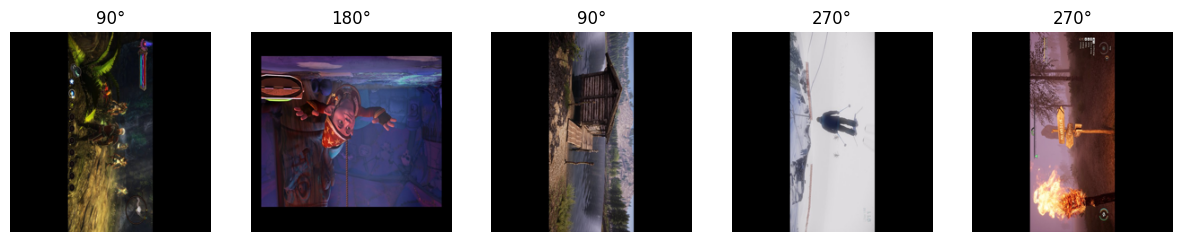

In [14]:
# Cell 2: Load & Visualize Data
train_df = pd.read_csv('/kaggle/input/kaust-vs-kku-tournament-round-1/Comp data/train.csv')  
test_df  = pd.read_csv('/kaggle/input/kaust-vs-kku-tournament-round-1/Comp data/test.csv')  

# Show a few samples
fig, axes = plt.subplots(1,5, figsize=(15,5))
for i, ax in enumerate(axes):
    row = train_df.sample(1, random_state=i+99699).iloc[0]
    img = Image.open(os.path.join(TRAIN_DIR, row['filename'])).resize((IMAGE_SIZE,)*2)
    ax.imshow(img)
    ax.set_title(f"{row['rotation']}°")
    ax.axis('off')
plt.show()


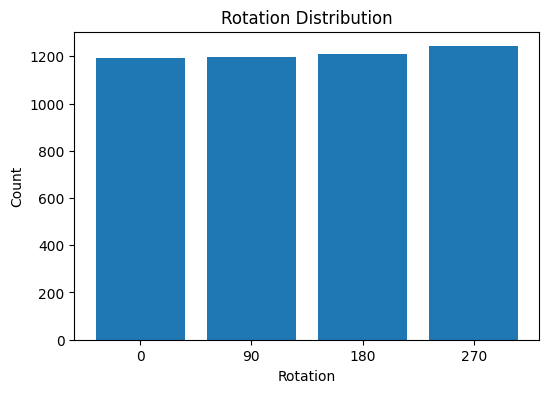

In [16]:
# Rotation histogram
plt.figure(figsize=(6,4))
plt.hist(train_df['rotation'], bins=[0,90,180,270,360], align='left', rwidth=0.8)
plt.xticks([0,90,180,270])
plt.xlabel('Rotation')
plt.ylabel('Count')
plt.title('Rotation Distribution')
plt.show()

In [17]:
import random
class ScreenshotDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.base_transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def remove_black_bars(self, img, threshold=0.9, black_threshold=10):
        img_gray = img.convert('L')
        arr = np.array(img_gray)
        mask_rows = np.mean(arr < black_threshold, axis=1) < threshold
        mask_cols = np.mean(arr < black_threshold, axis=0) < threshold
        rows = np.where(mask_rows)[0]
        cols = np.where(mask_cols)[0]
        if len(rows) and len(cols):
            img = img.crop((cols[0], rows[0], cols[-1]+1, rows[-1]+1))
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(TRAIN_DIR if self.mode=='train' else TEST_DIR,
                                row['filename'])
        img = Image.open(img_path).convert('RGB')
        

        if self.mode == 'train':
            # base label: 0,1,2,3 for 0°,90°,180°,270°
            label = row['rotation'] // 90

            # random horizontal flip
            if random.random() < 0.5:
                img = transforms.functional.hflip(img)
                # only 90° & 270° swap under a mirror
                if label == 1: label = 3 
                elif label == 3: label = 1
               
            # random 90° multiples rotation (CCW in PIL)
            k = random.randint(0, 3)
            if k > 0:
                img = img.rotate(-90 * k, expand=False)
                label = (label  +k ) % 4
            img = self.remove_black_bars(img)
            img = self.base_transform(img)
            return img, label

        else:
            img = self.base_transform(img)
            return img, row['filename']

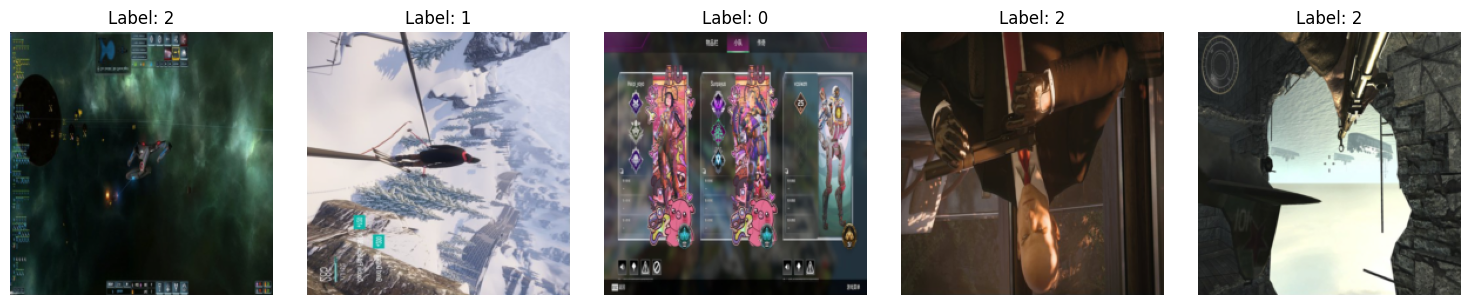

In [18]:
dataset = ScreenshotDataset(train_df, 'train') 
val_dataset =ScreenshotDataset(test_df, 'Valid') 

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = dataset[i]  # Or use random indices: dataset[random.randint(0, len(dataset)-1)]
    img_np = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    
    # Unnormalize for visualization
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)

    axes[i].imshow(img_np)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# instantiate & save initial weights
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
model = convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 4)

model = model.to(DEVICE)
torch.save(model.state_dict(), 'initial_weights.pth')  # for K-Fold restarts

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler    = GradScaler()   # for mixed-precision training

def train_one_epoch(loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, desc='Train', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def validate(loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Valid', leave=False):
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            total_loss += criterion(logits, y).item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:02<00:00, 88.5MB/s] 


In [20]:
# Cell 6: Stratified K-Fold Training + Early Stopping + OOF Collection

import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from torch.optim.lr_scheduler import CosineAnnealingLR  # already imported above

# assume ScreenshotDataset, train_one_epoch, validate, DEVICE,
# train_df, FOLDS, EPOCHS, BATCH_SIZE, LR, PATIENCE have been defined earlier

oof_preds = np.zeros(len(train_df), dtype=int)
oof_true  = train_df['rotation'].values // 90

train_losses_folds = []
val_losses_folds   = []

kf = GroupKFold(n_splits = FOLDS)
for fold, (tr_idx, va_idx) in enumerate(kf.split(train_df, train_df['rotation'], groups = train_df["game_label"])):
    print(f"▶ Fold {fold+1}")
    df_tr, df_va = train_df.iloc[tr_idx], train_df.iloc[va_idx]
    tr_ld = DataLoader(ScreenshotDataset(df_tr, 'train'),
                       batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
    va_ld = DataLoader(ScreenshotDataset(df_va, 'train'),
                       batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # reload fresh model & optimizer & scheduler for this fold
    model.load_state_dict(torch.load('initial_weights.pth'))
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    best_loss, patience = float('inf'), 0
    tl_fold, vl_fold  = [], []

    for ep in range(1, EPOCHS+1):
        tl = train_one_epoch(tr_ld)
        vl, va = validate(va_ld)
        print(f" Epoch {ep} → train_loss={tl:.4f}, val_loss={vl:.4f}, val_acc={va:.4f}")
        tl_fold.append(tl)
        vl_fold.append(vl)

        scheduler.step()  # cosine-anneal each epoch

        if vl < best_loss:
            best_loss = vl
            torch.save(model.state_dict(), f'best_fold{fold}.pth')
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE:
                print(" ⏹ Early stopping")
                break

    train_losses_folds.append(tl_fold)
    val_losses_folds.append(vl_fold)

    # collect OOF predictions for this fold
    model.load_state_dict(torch.load(f'best_fold{fold}.pth'))
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in DataLoader(ScreenshotDataset(df_va, 'train'),
                               batch_size=BATCH_SIZE, shuffle=False, num_workers=4):
            x = x.to(DEVICE)
            out = model(x).argmax(1).cpu().numpy()
            preds.extend(out)
    oof_preds[va_idx] = np.array(preds)

# overall OOF accuracy
oof_acc = accuracy_score(oof_true, oof_preds)
print(f"\nOverall OOF Accuracy: {oof_acc:.4f}")


▶ Fold 1


 Epoch 1 → train_loss=0.6726, val_loss=0.5415, val_acc=0.7942


 Epoch 2 → train_loss=0.3718, val_loss=0.8416, val_acc=0.6950


 Epoch 3 → train_loss=0.2928, val_loss=0.4985, val_acc=0.8016


 Epoch 4 → train_loss=0.2149, val_loss=0.4469, val_acc=0.8343


 Epoch 5 → train_loss=0.1825, val_loss=0.5261, val_acc=0.8028


 Epoch 6 → train_loss=0.1423, val_loss=0.5038, val_acc=0.8324


 Epoch 7 → train_loss=0.0954, val_loss=0.4972, val_acc=0.8355
 ⏹ Early stopping
▶ Fold 2


 Epoch 1 → train_loss=0.7200, val_loss=0.4312, val_acc=0.8055


 Epoch 2 → train_loss=0.4417, val_loss=0.3869, val_acc=0.8355


 Epoch 3 → train_loss=0.3542, val_loss=0.2827, val_acc=0.8768


 Epoch 4 → train_loss=0.2835, val_loss=0.2574, val_acc=0.8968


 Epoch 5 → train_loss=0.2026, val_loss=0.2642, val_acc=0.8881


 Epoch 6 → train_loss=0.1475, val_loss=0.3569, val_acc=0.8774


 Epoch 7 → train_loss=0.1359, val_loss=0.2981, val_acc=0.9012
 ⏹ Early stopping
▶ Fold 3


 Epoch 1 → train_loss=0.7377, val_loss=0.4784, val_acc=0.7990


 Epoch 2 → train_loss=0.3929, val_loss=0.4499, val_acc=0.8219


 Epoch 3 → train_loss=0.2956, val_loss=0.5541, val_acc=0.8101


 Epoch 4 → train_loss=0.2373, val_loss=0.3612, val_acc=0.8565


 Epoch 5 → train_loss=0.1714, val_loss=0.3774, val_acc=0.8411


 Epoch 6 → train_loss=0.1423, val_loss=0.3356, val_acc=0.8769


 Epoch 7 → train_loss=0.1089, val_loss=0.3766, val_acc=0.8726


 Epoch 8 → train_loss=0.0791, val_loss=0.3080, val_acc=0.8899


 Epoch 9 → train_loss=0.0598, val_loss=0.3371, val_acc=0.8862


 Epoch 10 → train_loss=0.0508, val_loss=0.3255, val_acc=0.8905

Overall OOF Accuracy: 0.2534


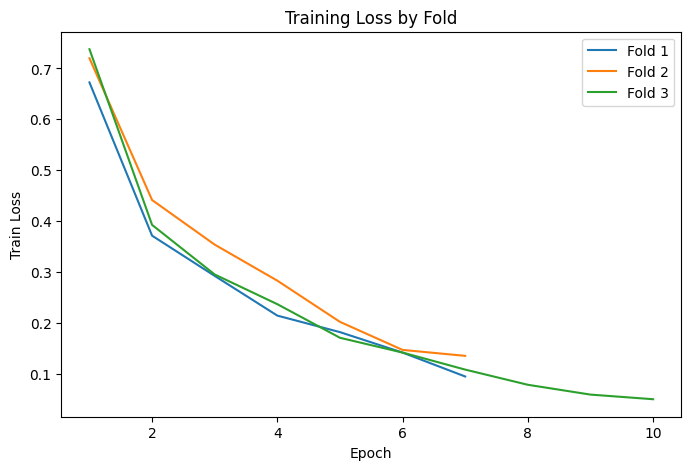

In [21]:
# Cell 7: Plot Training Loss per Fold
plt.figure(figsize=(8,5))
for i, tl in enumerate(train_losses_folds):
    plt.plot(range(1, len(tl)+1), tl, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss by Fold')
plt.legend()
plt.show()

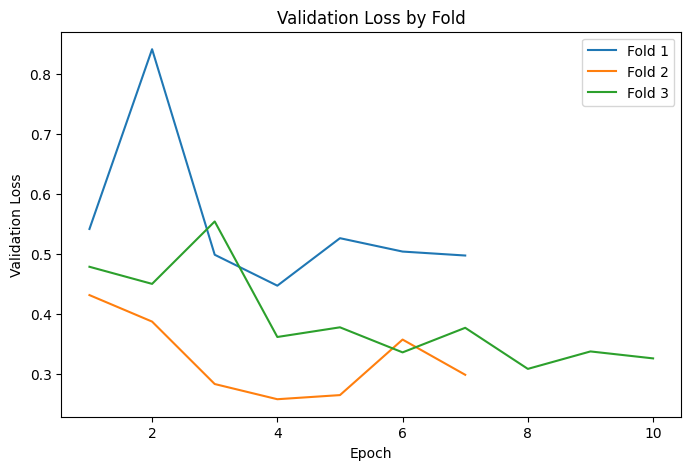

In [22]:
# Cell 8: Plot Validation Loss per Fold
plt.figure(figsize=(8,5))
for i, vl in enumerate(val_losses_folds):
    plt.plot(range(1, len(vl)+1), vl, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss by Fold')
plt.legend()
plt.show()

In [23]:
# Cell 8: Inference & Submission
test_ld = DataLoader(ScreenshotDataset(test_df,'test'), batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
model.eval()
preds=[]; fnames=[]
with torch.no_grad():
    for x,names in tqdm(test_ld, desc='Test'):
        x = x.to(DEVICE)
        out = model(x).argmax(1).cpu().numpy()
        preds.extend((out*90).tolist())
        fnames.extend(names)

sub = pd.DataFrame({'filename':fnames,'rotation':preds})
sub.to_csv('submission.csv', index=False)
print(sub.head())


Test: 100%|██████████| 29/29 [00:09<00:00,  3.21it/s]


         filename  rotation
0  test_00000.jpg        90
1  test_00001.jpg         0
2  test_00002.jpg        90
3  test_00003.jpg        90
4  test_00004.jpg         0
